# Kids Have Skills? 

# Is that really a thing?

# History

* The 50's
* ok

# Math

In [318]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import scale, normalize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [183]:
# %load_ext autoreload
# %autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

# Run this notebook outside of main module tree
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Import our libs
from surveys.personality import *
from utils.factors import *
from factor_rotation._analytic_rotation import target_rotation
from factor_rotation._gpa_rotation import orthomax_objective, GPA, rotateA as rotate
from factor_rotation._wrappers import rotate_factors

Populating the interactive namespace from numpy and matplotlib


In [3]:
X = prep_X(read_surveys("../data"))
bf_survey = X.iloc[:, 0:65]
bf_survey_scaled = pd.DataFrame(scale(bf_survey))
others = X.iloc[:, 65:]
others_scaled = pd.DataFrame(scale(others))
ids = read_surveys("../data").user_id

# Get the big five components, sparse positie loadings for the questions that
# refer to personality traits. 
bigfive_key = pd.read_csv("../data/educatalyst/Auxil/q1_key_bigfive.csv")
bf_comps = get_big_five_comps(bigfive_key)

# Projec the survey data onto those big five personality components
bigfive = big_five_projection(bigfive_key, bf_survey)
bigfive_scaled = big_five_projection(bigfive_key, bf_survey_scaled)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [403]:
def get_exlained_variance(df, L, PCA = True, p = 5):
    # sklearn mangles the PCA loadings, so we treat it differently
    if PCA:
        F = df.dot(normalize(L).T)
        v =  np.var(F, axis=0)/np.var(df).sum() * 100 
    else:
        v = np.sum(L ** 2, axis=1)/np.var(df).sum() * 100
    print 'Summed variance of first %s components: %s' % (p,v[0:p].sum())
    return v

def plot_corr(A, B):
    corr = np.corrcoef(A, B, rowvar = False)
    p = sns.heatmap(pd.DataFrame(corr), center=0)
    plt.show()
    print max_corr(A, B) 
    
def rotated_fa(X, rotator, rotate_factors=True, comps=5):
    """ rotator gets called with F factor matrix """
    fa = RotatableFA(comps).fit(X)
    F = fa.transform(X)
    T = rotator(F)
    fa.rotate_components(rotator, rotate_factors)
    F = fa.transform(X)
    return fa.components_,F

def varimax_gpa(F, Y, rotation_method = 'orthogonal', ff = None):
    T = target_rotation(F, Y)
    ff = VarimaxCorrelationObjective(Y) if ff is None else ff
    _,_,T,_ = GPA(F, ff = ff, T = T, rotation_method=rotation_method)
    return T

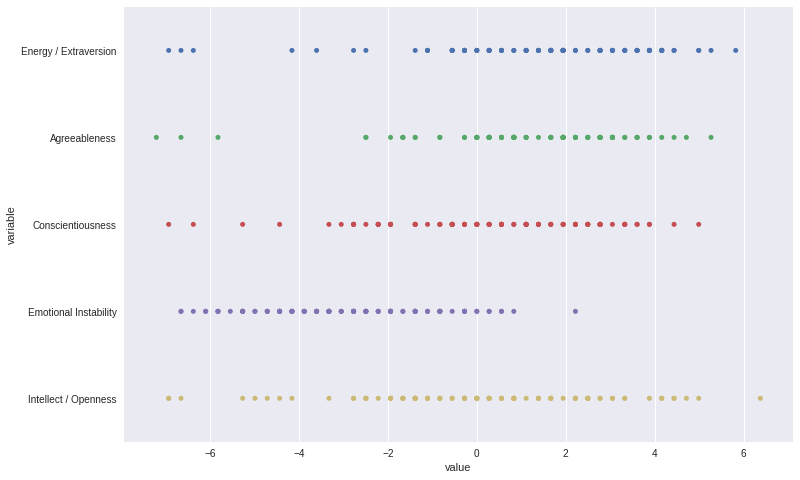

In [196]:
sns.stripplot(x = 'value', y = 'variable', data = pd.melt(bigfive), orient = 'h')
plt.show()

In [319]:
bf_pca = PCA(5).fit(bf_survey_scaled)
A = bf_pca.components_.T
V,T = rotate_factors(A, 'varimax')
n = np.stack([
        get_exlained_variance(bf_survey_scaled, A.T), 
        get_exlained_variance(bf_survey_scaled, V.T),
        get_exlained_variance(bf_survey_scaled, bf_comps.T)]).T

pd.DataFrame(n, columns=["Components", "Varimax", "Big Five"])

,Components,Varimax,Big Five
0,23.543123,14.691594,7.569611
1,7.580135,5.573418,7.590264
2,6.321525,12.284804,7.664056
3,5.111549,7.432257,6.073631
4,3.795437,6.369697,8.321417


Summed variance of first 5 components: 46.3517700504
Summed variance of first 5 components: 46.3517700504
Summed variance of first 5 components: 37.2189799093


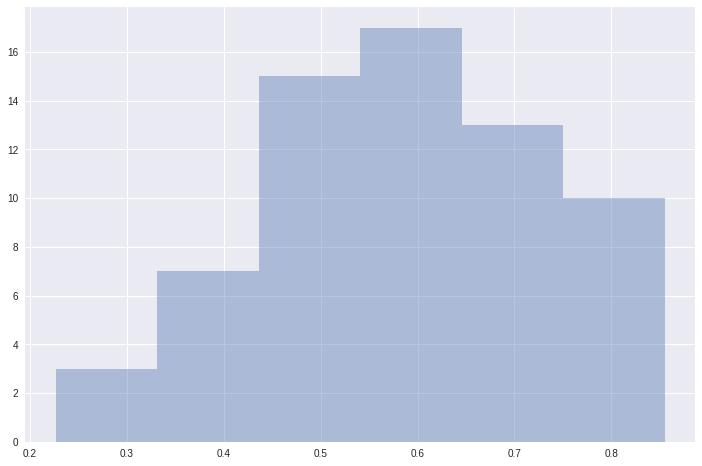

In [418]:
fa = RotatableFA(5).fit(bf_survey_scaled)
F = fa.transform(bf_survey_scaled)
d = sns.distplot(fa.noise_variance_, kde=False)

In [320]:
A,FA = rotated_fa(bf_survey_scaled, lambda F: np.eye(F.shape[1]))
V,FV = rotated_fa(bf_survey_scaled, lambda L: rotate_factors(L.T, 'varimax')[1], False)

n = np.stack([
        get_exlained_variance(bf_survey_scaled, A, False), 
        get_exlained_variance(bf_survey_scaled, V, False),
        get_exlained_variance(bf_survey_scaled, bf_comps.T)]).T

pd.DataFrame(n, columns=["Components", "Varimax", "Big Five"])

,Components,Varimax,Big Five
0,22.586949,13.645560,7.569611
1,6.474895,10.342161,7.590264
2,5.544954,7.858926,7.664056
3,4.367940,4.543434,6.073631
4,2.922496,5.507152,8.321417


Summed variance of first 5 components: 41.8972335086
Summed variance of first 5 components: 41.8972335086
Summed variance of first 5 components: 37.2189799093


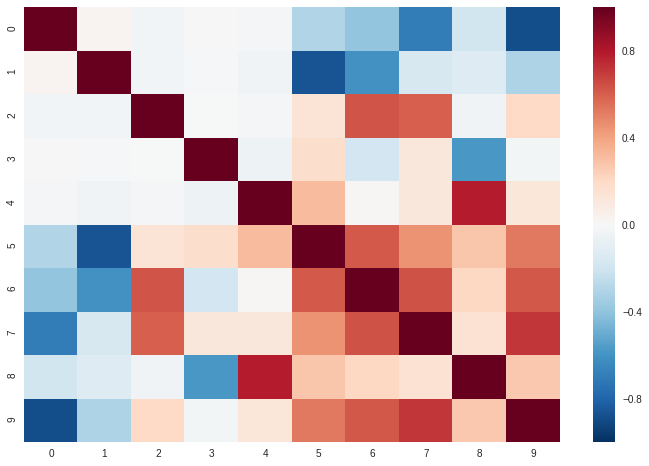

[ 0.18891878  0.12607264  0.62830033  0.17289668  0.78149846]


In [404]:
# Basic Factor Analysis on Big Five Survey without rotation
L,F = rotated_fa(bf_survey_scaled, lambda F: np.eye(F.shape[1]))
plot_corr(FV, bigfive)

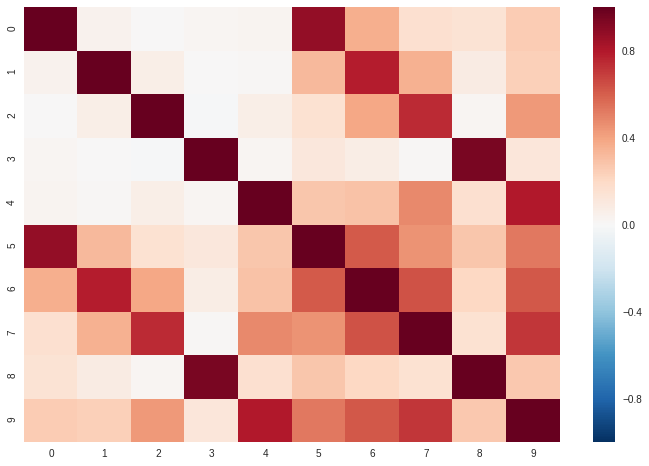

[ 0.88173985  0.78164744  0.74798731  0.95296956  0.80297988]


In [393]:
# Factor Analysis with factors rotated to minimize L2 Norm with Big Five
L,F = rotated_fa(bf_survey_scaled, lambda F: target_rotation(F, bigfive))
plot_corr(F, bigfive)

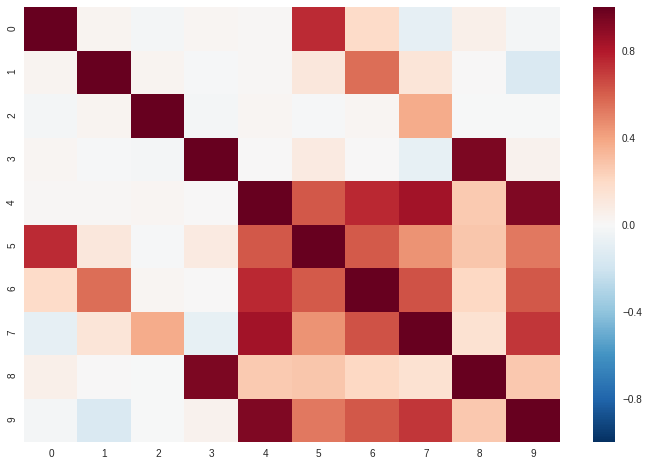

[ 0.74813693  0.55708017  0.36998887  0.93868981  0.93258694]


In [345]:
# Factor Analysis with factors rotated in order to maximize Varimax objective
# in the correlation matrix with the bigfive factors.
L,F = rotated_fa(bf_survey_scaled, lambda F: varimax_gpa(F, bigfive))
plot_corr(F, bigfive)

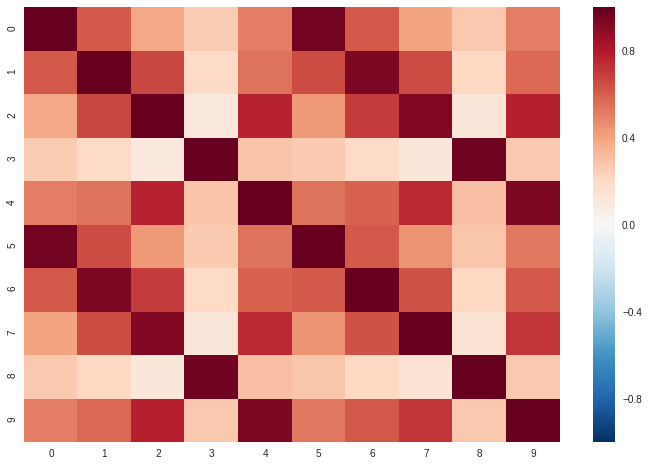

[ 0.9685459   0.94309155  0.92232594  0.97342428  0.94215075]


In [346]:
L,F = rotated_fa(bf_survey_scaled, lambda F: varimax_gpa(F, bigfive, 'oblique'))
plot_corr(F, bigfive)

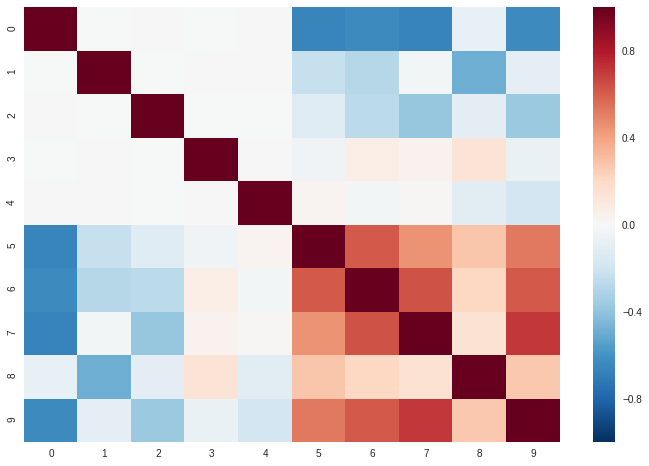

[ 0.08387914  0.02588373  0.10717633  0.13425402  0.03120745]


In [405]:
L,F = rotated_fa(others_scaled, lambda F: np.eye(F.shape[1]))
plot_corr(F, bigfive)

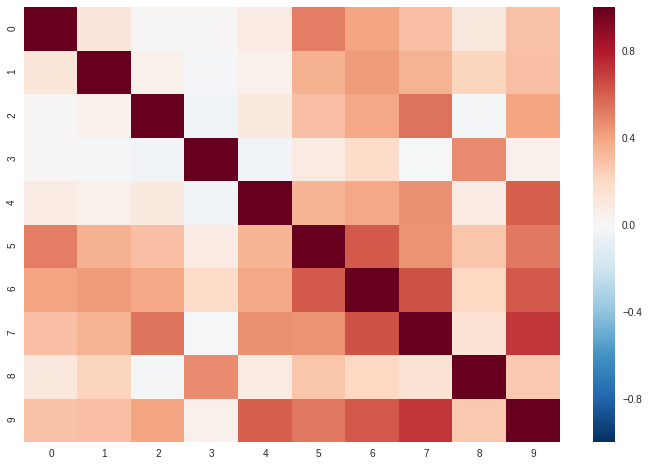

[ 0.51275304  0.42301736  0.54648986  0.46932071  0.60056839]


In [347]:
L,F = rotated_fa(others_scaled, lambda F: target_rotation(F, bigfive))
plot_corr(F, bigfive)

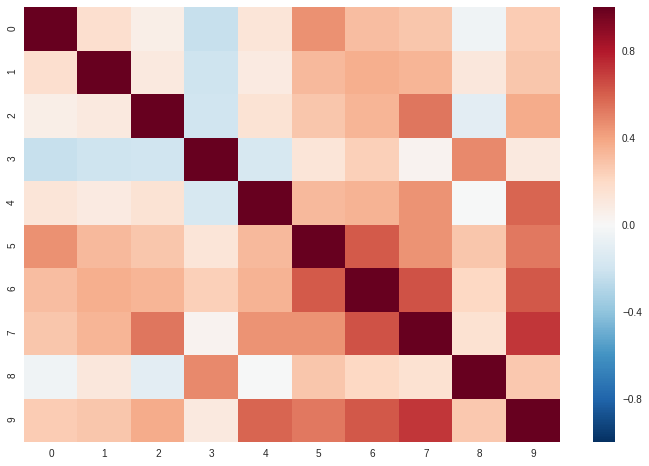

[ 0.45927976  0.36463528  0.53494819  0.48146071  0.58080841]


In [348]:
def norm(A=None, T=None, L=None):
    L = A.dot(T) if L is None else L
    return np.linalg.norm(L - bigfive, 1)
    
L,F = rotated_fa(others_scaled, lambda F: varimax_gpa(F, bigfive, 'oblique', norm))
plot_corr(F, bigfive)

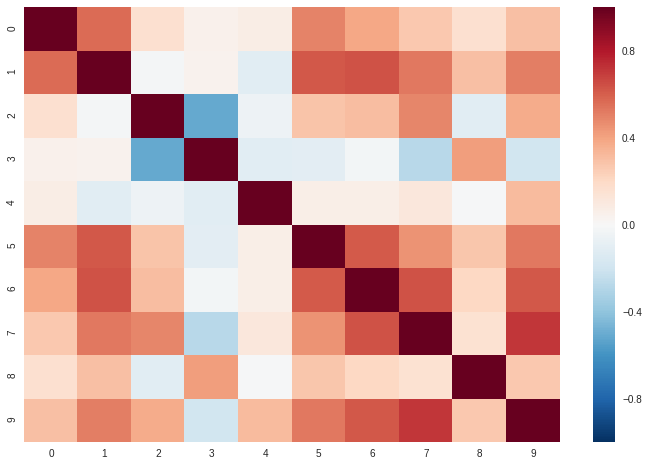

[ 0.49359586  0.63905825  0.48940927  0.42176986  0.3127845 ]


In [349]:
L,F = rotated_fa(others_scaled, lambda F: varimax_gpa(F, bigfive, 'oblique'))
plot_corr(F, bigfive)

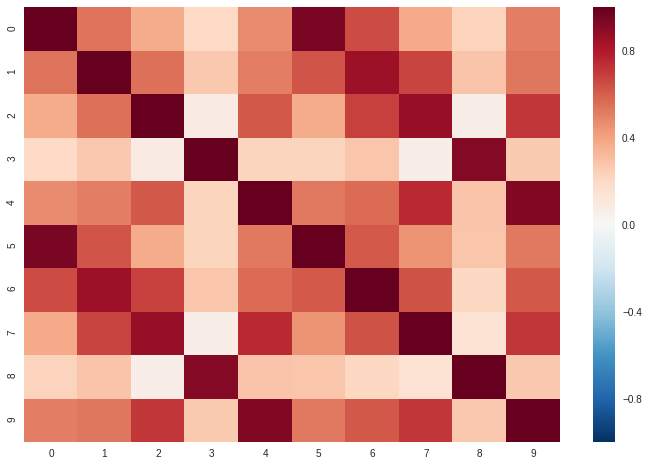

[ 0.94824938  0.85805373  0.87439256  0.91508571  0.92328544]
Summed variance of first 5 components: 41.7923318685


In [406]:
from sklearn.cross_decomposition import PLSSVD
plssvd = PLSSVD(5).fit(bf_survey_scaled, others_scaled)
T = target_rotation(plssvd.x_scores_, bigfive)
F = rotate(plssvd.x_scores_, T)
plot_corr(F, bigfive)
max_corr(F, bigfive)
g = get_exlained_variance(bf_survey, plssvd.x_weights_.T)

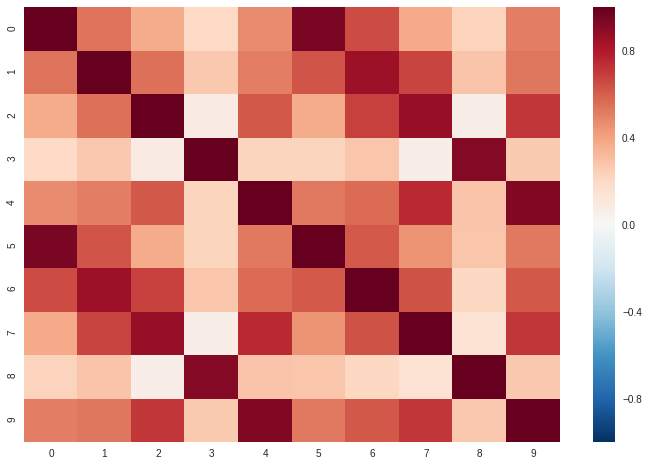

[ 0.94824938  0.85805373  0.87439256  0.91508571  0.92328544]
Summed variance of first 5 components: 41.7923318685


In [407]:
T = target_rotation(plssvd.x_scores_, bigfive)
F = rotate(plssvd.x_scores_, T)
plot_corr(F, bigfive)
max_corr(F, bigfive)
g = get_exlained_variance(bf_survey, plssvd.x_weights_.T)

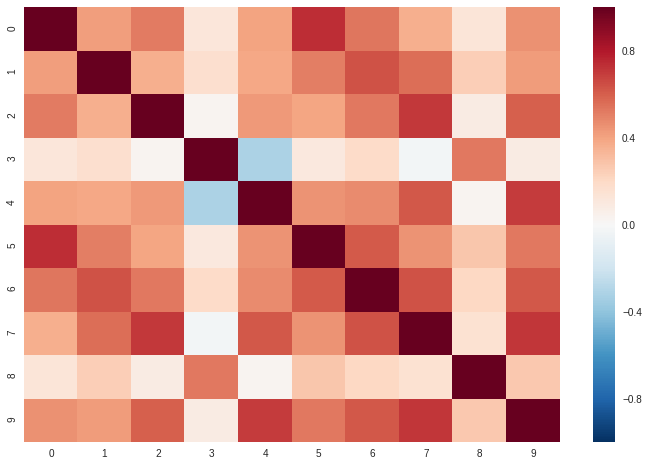

[ 0.74175469  0.63407187  0.70374776  0.53098374  0.69675451]
Summed variance of first 5 components: 41.1344585457


In [409]:
F = rotate(plssvd.y_scores_, T) 
plot_corr(F, bigfive)
g = get_exlained_variance(others, plssvd.y_weights_.T)

# Elastic Net

$$
\DeclareMathOperator*{\argmin}{argmin}
\hat{\beta} = argmin_{\beta}||y - \mathbf{X}\beta ||^2 + \lambda_2|| \beta ||^2 + \lambda_1 || \beta ||_1
$$

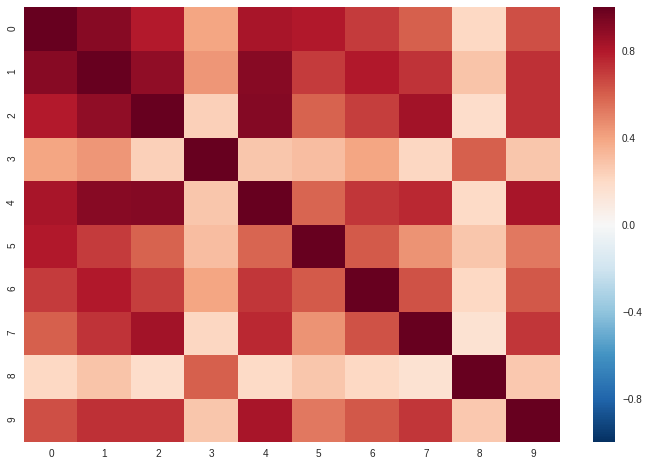

[ 0.80027118  0.80359245  0.84047172  0.59949781  0.8253834 ]
Summed variance of first 5 components: 39.3411583718


In [410]:
enet = MultiElasticNet(alpha = 0.4, l1_ratio = .5)
fitted = enet.fit(others, bigfive.as_matrix())
L = np.array(enet.coef_).T
plot_corr(others_scaled.dot(L), bigfive)
g = get_exlained_variance(others, enet.coef_)